In [ ]:
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [2]:
df = pd.read_csv('../data/new/albums_final.csv')

In [3]:
img_dir = "../../album_images"
df['filepath'] = df['album_id'].apply(lambda x: os.path.join(img_dir, (x + '.jpg')))
df = df[df['filepath'].apply(os.path.exists)]  # Drop missing files

In [7]:
# Parameters
image_size = (64, 64)  # Match your CNN input shape
label_column = 'popularity'

X = []
y = []

for _, row in df.iterrows():
    try:
        img = Image.open(row['filepath']).resize(image_size).convert('RGB')  # force RGB
        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading image {row['filepath']}: {e}")

X = np.array(X)
y = np.array(y).astype(np.float32)  # Regression → float labels


In [11]:
# Wrap in tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# Split into train/val
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Setup performance pipeline
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .shuffle(1000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_dataset
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)

In [15]:
model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(32, (3, 3), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Conv Block 3
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

# Output layer (regression)
model.add(layers.Dense(1))

# Early stopping
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

# Fit the model
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])

/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,169 (2.47 MB)

 Trainable params: 646,721 (2.47 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 3459.0222 - mean_absolute_error: 56.4980 - val_loss: 1378.7444 - val_mean_absolute_error: 33.0378
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 3078.0352 - mean_absolute_error: 53.1079 - val_loss: 1212.2703 - val_mean_absolute_error: 30.5116
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 2627.4685 - mean_absolute_error: 48.7768 - val_loss: 1010.9674 - val_mean_absolute_error: 27.2582
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 2205.6775 - mean_absolute_error: 44.1204 - val_loss: 721.4723 - val_mean_absolute_error: 22.1922
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1674.5551 - mean_absolute_error: 37.8355 - val_loss: 492.2433 - val_mean_absolute_error: 17.8517
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 1195.6571 - mean_absolute_error: 31.2290 - val_loss: 313.4995 - val_mean_absolute_error: 14.2951
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 84

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


2025-04-20 12:09:44.008031: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


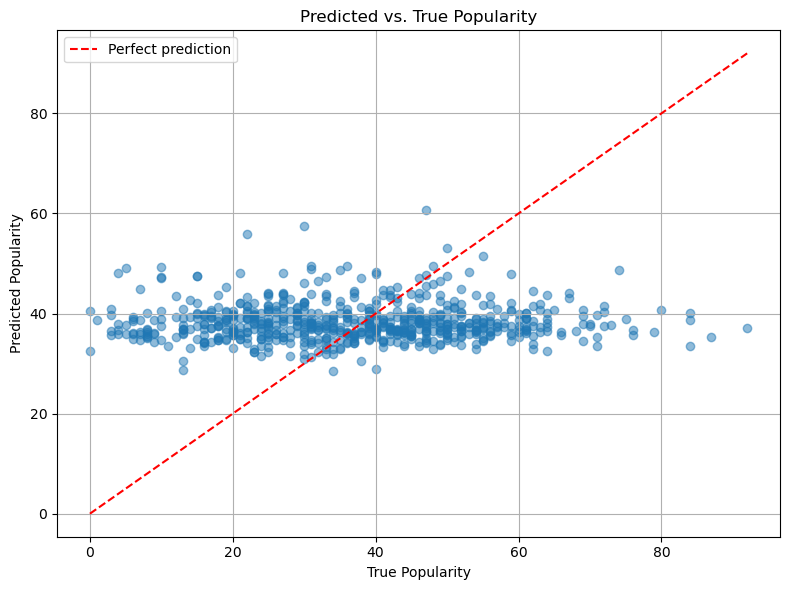

In [16]:
# Extract true labels and images from the validation dataset
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred.extend(preds.flatten())
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Perfect prediction')
plt.xlabel("True Popularity")
plt.ylabel("Predicted Popularity")
plt.title("Predicted vs. True Popularity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [33]:
# 1. Bin popularity into two classes: Top album vs Not Top
df['popularity_class'] = df['popularity'].apply(lambda x: 1 if x >= 55 else 0)
label_column = 'popularity_class'

# 2. Convert images and labels
X = []
y = []

for _, row in df.iterrows():
    image_path = os.path.join(img_dir, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize(image_size)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)

# 3. Create tf.data.Dataset from full dataset
dataset = tf.data.Dataset.from_tensor_slices((X, y))

# ✅ Shuffle BEFORE split!
dataset = dataset.shuffle(buffer_size=len(X), reshuffle_each_iteration=False)

# 4. Train/val split
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# 5. Batch and prefetch
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

# 6. Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def preprocess(image, label):
    image = data_augmentation(image)
    return image, label

# 7. Apply only to train set
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)


model = models.Sequential()

# Conv Block 1
model.add(layers.Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(64, 64, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))  # Added dropout

# Conv Block 2
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Conv Block 3
model.add(layers.Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.3))

# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))  # Heavier dropout here

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))

# Early stopping
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model
model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=[callback])

Epoch 1/50


/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.5056 - loss: 1.1165 - val_accuracy: 0.4772 - val_loss: 0.9664
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5129 - loss: 1.0291 - val_accuracy: 0.4818 - val_loss: 0.9826
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5273 - loss: 0.9810 - val_accuracy: 0.4757 - val_loss: 0.9315
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5246 - loss: 0.9623 - val_accuracy: 0.4985 - val_loss: 0.9123
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5160 - loss: 0.9291 - val_accuracy: 0.4985 - val_loss: 0.8958
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5166 - loss: 0.9097 - val_accuracy: 0.5319 - val_loss: 0.8704
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5306 - loss: 0.8823 - val_accuracy: 0.5106 - val_loss: 0.8551
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5315 - loss: 0.8576 - val_accuracy: 0.5228 - val_loss: 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


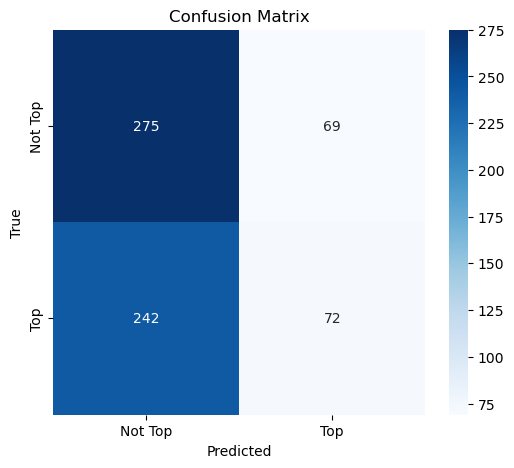

In [34]:
# Get model predictions on the validation dataset
y_pred = model.predict(val_dataset)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary class labels

# Get the true labels from the validation dataset
y_true = np.concatenate([y for _, y in val_dataset], axis=0)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Top", "Top"], yticklabels=["Not Top", "Top"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [35]:
# Bin popularity into two classes if not already done
df['popularity_class'] = df['popularity'].apply(lambda x: 1 if x >= 55 else 0)
label_column = 'popularity_class'

# Step 1: Preprocess images with EfficientNet preprocessing
X = []
y = []

for _, row in df.iterrows():
    image_path = os.path.join(img_dir, f"{row['album_id']}.jpg")
    try:
        img = Image.open(image_path).resize((224, 224))  # EfficientNet prefers 224x224
        img_array = preprocess_input(np.array(img))  # EfficientNet preprocessor
        X.append(img_array)
        y.append(row[label_column])
    except Exception as e:
        print(f"Error loading {image_path}: {e}")

X = np.array(X)
y = np.array(y)

# Wrap in tf.data
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=len(dataset), reshuffle_each_iteration=False)

# Train/val split
train_size = int(0.8 * len(X))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.batch(batch_size).prefetch(AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(AUTOTUNE)

# Step 2: Build model with EfficientNetB0 base
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callback = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# Step 3: Train
model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=[callback])


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.5154 - loss: 0.7230 - val_accuracy: 0.5714 - val_loss: 0.6777
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 366ms/step - accuracy: 0.5755 - loss: 0.6749 - val_accuracy: 0.5866 - val_loss: 0.6753
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 367ms/step - accuracy: 0.6240 - loss: 0.6486 - val_accuracy: 0.5897 - val_loss: 0.6710
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 364ms/step - accuracy: 0.6387 - loss: 0.6404 - val_accuracy: 0.6079 - val_loss: 0.6742
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 30s 363ms/step - accuracy: 0.6379 - loss: 0.6309 - val_accuracy: 0.6049 - val_loss: 0.6745
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 371ms/step - accuracy: 0.6591 - loss: 0.6271 - val_accuracy: 0.6079 - val_loss: 0.6764
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.
